In [4]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoTokenizer

In [7]:
olmoe_tokenizer = AutoTokenizer.from_pretrained("/Users/pingzhili/huggingface-repo/allenai/OLMoE-1B-7B-0125-Instruct")
# moonlight_tokenizer = AutoTokenizer.from_pretrained("moonshotai/Moonlight-16B-A3B-Instruct", trust_remote_code=True)

In [8]:
olmoe_distilled = torch.load(
    "/Users/pingzhili/huggingface-repo/distill-moe-hidden-states/olmoe-distill-4000/router_tokens.pt",
    map_location="cpu")
olmoe_original = torch.load(
    "/Users/pingzhili/huggingface-repo/distill-moe-hidden-states/olmoe-original/router_tokens.pt", map_location="cpu")
moonlight = torch.load(
    "/Users/pingzhili/huggingface-repo/distill-moe-hidden-states/moonlight/router_tokens.pt", map_location="cpu"
)

/var/folders/nb/s6rx6vkd76jgjf_v647g39r40000gn/T/ipykernel_23887/123433521.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  olmoe_distilled = torch.load(
/var/folders/nb/

In [9]:
olmoe_distilled.keys(), olmoe_distilled['model.layers.0.mlp'].keys(), type(
    olmoe_distilled['model.layers.0.mlp']['input']), olmoe_distilled['model.layers.0.mlp']['input'].__len__(), \
    olmoe_distilled['model.layers.0.mlp']['input'][0].shape, len(
    olmoe_distilled['model.layers.0.mlp']['selected_experts']), \
    olmoe_distilled['model.layers.0.mlp']['selected_experts'][0].shape

(dict_keys(['model.layers.0.mlp', 'model.layers.1.mlp', 'model.layers.2.mlp', 'model.layers.3.mlp', 'model.layers.4.mlp', 'model.layers.5.mlp', 'model.layers.6.mlp', 'model.layers.7.mlp', 'model.layers.8.mlp', 'model.layers.9.mlp', 'model.layers.10.mlp', 'model.layers.11.mlp', 'model.layers.12.mlp', 'model.layers.13.mlp', 'model.layers.14.mlp', 'model.layers.15.mlp', 'input_ids']),
 dict_keys(['input', 'selected_experts']),
 list,
 280,
 torch.Size([796, 2048]),
 280,
 torch.Size([796, 8]))

In [ ]:
moonlight.keys()

In [ ]:
moonlight.keys(), moonlight['model.layers.2.mlp'].keys(), type(
    moonlight['model.layers.2.mlp']['input']), moonlight['model.layers.2.mlp']['input'].__len__(), \
    moonlight['model.layers.2.mlp']['input'][0].shape, len(
    moonlight['model.layers.2.mlp']['selected_experts']), \
    moonlight['model.layers.2.mlp']['selected_experts'][0].shape

In [11]:
type(olmoe_distilled["input_ids"]), olmoe_distilled["input_ids"].__len__(), olmoe_distilled["input_ids"][0].shape

(list, 280, torch.Size([796]))

In [18]:
NUM_DIFF_THRESHOLD = 0
top_k = 4


def find_tokens_with_changed_routing(olmoe_original, olmoe_distilled):
    """
    Identify tokens whose routing has completely changed after distillation.
    """
    changed_tokens = {}

    # Iterate through layers
    for layer_idx in range(16):  # Adjust if you have a different number of layers
        layer_key = f'model.layers.{layer_idx}.mlp'
        if layer_key not in olmoe_original or layer_key not in olmoe_distilled:
            continue

        changed_tokens[layer_key] = []

        # For each sample
        for sample_idx in range(len(olmoe_original['input_ids'])):
            sample_changes = []
            seq_len = len(olmoe_original['input_ids'][sample_idx])

            # Get experts for this sample in both models
            orig_experts = olmoe_original[layer_key]['selected_experts'][sample_idx][:seq_len, :top_k]
            dist_experts = olmoe_distilled[layer_key]['selected_experts'][sample_idx][:seq_len, :top_k]
            input_ids = olmoe_original['input_ids'][sample_idx]

            # Check each token
            for token_idx in range(seq_len):
                orig_set = set(orig_experts[token_idx].tolist())
                dist_set = set(dist_experts[token_idx].tolist())

                # If no overlap in experts, routing has completely changed
                if len(orig_set.intersection(dist_set)) <= NUM_DIFF_THRESHOLD:
                    token_id = input_ids[token_idx].item()
                    sample_changes.append({
                        'token_idx': token_idx,
                        'token_id': token_id,
                        'orig_experts': orig_experts[token_idx].tolist(),
                        'dist_experts': dist_experts[token_idx].tolist()
                    })

            if sample_changes:
                changed_tokens[layer_key].append({
                    'sample_idx': sample_idx,
                    'changes': sample_changes
                })

    return changed_tokens


def analyze_routing_patterns(olmoe_original, olmoe_distilled, changed_tokens, tokenizer=None):
    """
    Analyze routing patterns to identify distillation fingerprints.
    """
    # 1. Count changes per layer
    layer_counts = {}
    for layer_key, samples in changed_tokens.items():
        total_changes = sum(len(sample['changes']) for sample in samples)
        layer_counts[layer_key] = total_changes

    # 2. Analyze embedding similarities between original and distilled models
    similarities = {}
    for layer_key, samples in changed_tokens.items():
        similarities[layer_key] = []
        for sample in samples:
            sample_idx = sample['sample_idx']
            orig_inputs = olmoe_original[layer_key]['input'][sample_idx]
            dist_inputs = olmoe_distilled[layer_key]['input'][sample_idx]

            for change in sample['changes']:
                token_idx = change['token_idx']
                orig_emb = orig_inputs[token_idx]
                dist_emb = dist_inputs[token_idx]

                sim = torch.nn.functional.cosine_similarity(
                    orig_emb.unsqueeze(0), dist_emb.unsqueeze(0)
                ).item()

                similarities[layer_key].append({
                    'token_id': change['token_id'],
                    'similarity': sim
                })

    # 3. Count token occurrences to find patterns
    token_counts = Counter()
    for layer_key, samples in changed_tokens.items():
        for sample in samples:
            for change in sample['changes']:
                token_counts[change['token_id']] += 1

    # Decode most common tokens if tokenizer is provided
    most_common = token_counts.most_common(50)
    if tokenizer:
        most_common = [(tid, count, tokenizer.decode([tid])) for tid, count in most_common]

    # 4. Analyze expert transitions (which experts in original route to which experts in distilled)
    expert_transitions = {}
    for layer_key, samples in changed_tokens.items():
        transitions = Counter()
        for sample in samples:
            for change in sample['changes']:
                # Instead of full transitions (too many combinations), calculate statistics
                # on how experts change
                for orig_exp in change['orig_experts']:
                    for dist_exp in change['dist_experts']:
                        transitions[(orig_exp, dist_exp)] += 1

        expert_transitions[layer_key] = transitions

    # Return analysis results
    return {
        'layer_counts': layer_counts,
        'similarities': similarities,
        'most_common_tokens': most_common,
        'expert_transitions': expert_transitions
    }


def visualize_patterns(analysis_results, tokenizer=None):
    """
    Create visualizations to help identify distillation patterns.
    """
    # 1. Distribution of changes across layers
    plt.figure(figsize=(6, 4))
    layer_indices = [int(layer_key.split('.')[2]) for layer_key in analysis_results['layer_counts'].keys()]
    counts = list(analysis_results['layer_counts'].values())

    # Sort by layer index
    sorted_indices = np.argsort(layer_indices)
    layer_indices = [layer_indices[i] for i in sorted_indices]
    counts = [counts[i] for i in sorted_indices]

    plt.bar(layer_indices, counts, color="#A31F34")
    plt.xlabel('Layer Index')
    plt.ylabel('Number of Tokens with Changed Routing')
    plt.title('Distribution of Completely Changed Routing Tokens Across Layers')
    plt.grid(axis='y', alpha=0.3)
    plt.savefig('routing_changes_by_layer.png')

    # 2. Embedding similarity distribution
    all_sims = []
    for layer_sims in analysis_results['similarities'].values():
        all_sims.extend([item['similarity'] for item in layer_sims])

    if all_sims:
        plt.figure(figsize=(6, 4))
        plt.hist(all_sims, bins=30, color="#A31F34")
        plt.axvline(x=np.mean(all_sims), color="gray", linestyle='--',
                    label=f'Mean: {np.mean(all_sims):.3f}')
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Count')
        plt.title('Embedding Similarities for Tokens with Changed Routing')
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.savefig('embedding_similarities.png')

    # 3. Most common tokens with changed routing
    if analysis_results['most_common_tokens']:
        plt.figure(figsize=(15, 4))
        if tokenizer and len(analysis_results['most_common_tokens'][0]) == 3:
            labels = [text for _, _, text in analysis_results['most_common_tokens']]
            values = [count for _, count, _ in analysis_results['most_common_tokens']]
        else:
            labels = [f'Token {tid}' for tid, _ in analysis_results['most_common_tokens']]
            values = [count for _, count in analysis_results['most_common_tokens'] if count > 1]

        plt.bar(labels, values, color="#A31F34")
        plt.xlabel('Token')
        plt.ylabel('Count')
        plt.title('Most Common Tokens with Changed Routing (Count > 1)')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig('most_common_tokens.png')

In [19]:
changed_tokens = find_tokens_with_changed_routing(olmoe_original, olmoe_distilled)

In [20]:
routing_patterns = analyze_routing_patterns(olmoe_original, olmoe_distilled, changed_tokens, tokenizer=olmoe_tokenizer)

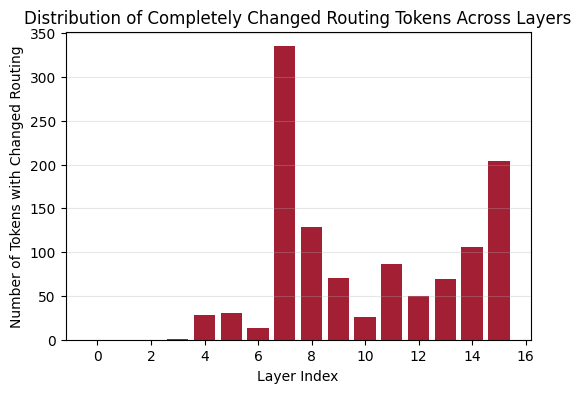

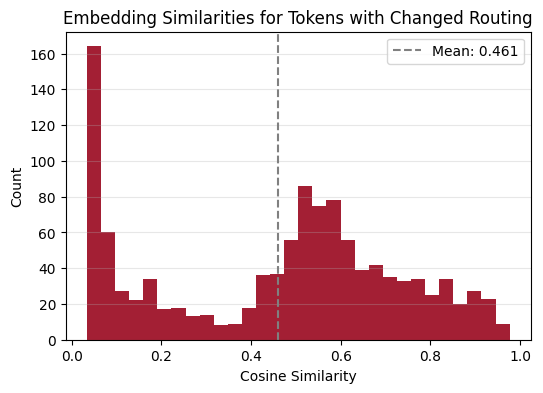

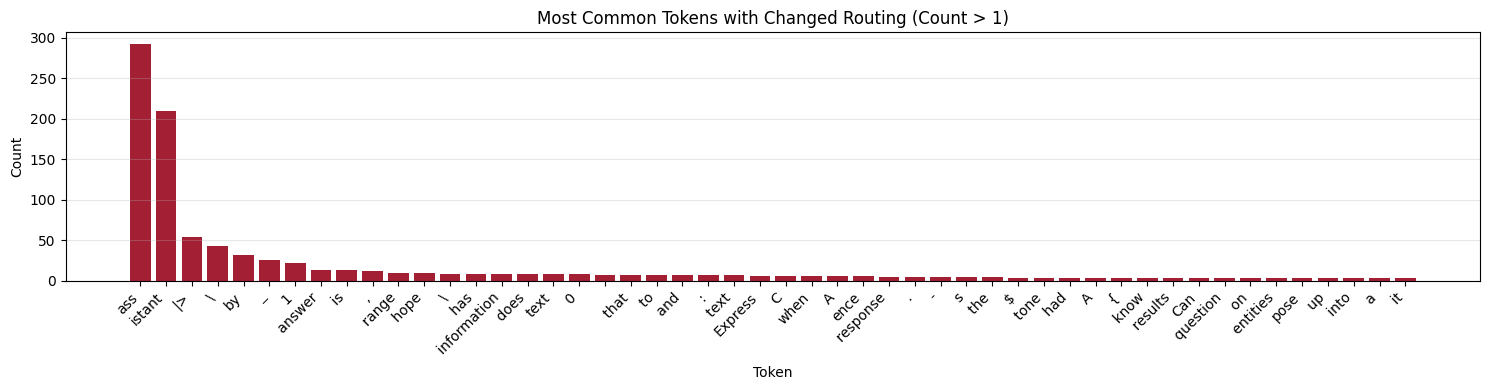

In [21]:
visualize_patterns(routing_patterns, tokenizer=olmoe_tokenizer)